# Set 7 – Text Mining & NLP Assignment

## Dataset: AG News Classification Dataset  
Source: Kaggle – AG News Classification Dataset  

### Group Details:
Group No: 78

#### Group Members:
1.   AVINASH GUPTA - 2023DC04310
2.   BHAVYA ARORA - 2023DA04058
3.   BANDARU HAREESHA - 2024DA04089
4.   SANJANA V KULKARNI - 2024DA04217

---

## Objective
Part I: Use a probabilistic language model (Trigram) for sentence recommendation.
Part II: Perform text preprocessing, TF-IDF feature extraction, and similarity analysis.

How to run — Quick steps:
1. Run the first cell to install dependencies (%pip install ...).
2. Run the NLTK resources cell to download/check necessary corpora (punkt, stopwords, wordnet, etc.).
3. Ensure train.csv (AG News dataset) is present in the current working directory or set `csv_path` to the dataset path.
4. Execute the notebook in order (Kernel → Restart & Run All) to reproduce results.

Notes:
- Trigram comparisons use log-probabilities (with Laplace smoothing) to avoid zero counts and numerical underflow.
- TF-IDF uses `max_features=5000` for memory efficiency; PCA visualizes a 2D subset of word vectors.


In [64]:
# Install dependencies into the notebook kernel (only if not present)
%pip install -q pandas numpy nltk scikit-learn matplotlib seaborn


4724.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [65]:
import sys
print('Python executable:', sys.executable)
print('Python version:', sys.version)
import site
print('Site packages:', site.getsitepackages() if hasattr(site, 'getsitepackages') else site.getusersitepackages())


Python executable: /Library/Developer/CommandLineTools/usr/bin/python3
Python version: 3.9.6 (default, Apr 30 2025, 02:07:17) 
[Clang 17.0.0 (clang-1700.0.13.5)]
Site packages: ['/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site-packages', '/Library/Python/3.9/site-packages', '/AppleInternal/Library/Python/3.9/site-packages', '/AppleInternal/Tests/Python/3.9/site-packages']


In [66]:
##Import Libraries
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA


In [67]:
##Download NLTK Resources

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hareeshabandaru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hareeshabandaru/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hareeshabandaru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hareeshabandaru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hareeshabandaru/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hareeshabandaru/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [68]:
# Dataset instructions: ensure the AG News 'train.csv' is in the current working directory (kernel's cwd) or specify its full path in `csv_path`
# You can obtain the dataset from Kaggle (AG News - 'train.csv') and place it in the working directory or provide the full path
# After ensuring the file is present, run the following cell to load the data; if missing, the code will raise an informative FileNotFoundError
# If you are using Colab/Kaggle, upload it to the session or mount your Drive and update `csv_path` accordingly


In [69]:
import os
csv_path = 'train.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError("train.csv not found. Please download the AG News train.csv from Kaggle and place it in the current working directory (kernel's cwd), or set csv_path to the full filesystem path to the dataset.")
df = pd.read_csv(csv_path, header=None, names=["class", "title", "description"])
df.head()


,class,title,description
0,Class Index,Title,Description
1,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [70]:
print("Dataset Shape:", df.shape)
print("\nClass Distribution:\n", df['class'].value_counts())

Dataset Shape: (120001, 3)

Class Distribution:
 class
3              30000
4              30000
2              30000
1              30000
Class Index        1
Name: count, dtype: int64


The AG News dataset contains news articles categorized into:
- World
- Sports
- Business
- Science/Technology

For this assignment, the entire dataset is used as a **training corpus**.
We use the `description` column of each article to build the probabilistic
trigram language model and to extract TF-IDF features for similarity analysis.


**PART 1 - Trigram Language Model**

In [71]:
##Prepare Training Corpus
corpus = df['description'].astype(str).tolist()


In [72]:
##Tokenization with Sentence Boundaries
def tokenize_corpus(texts):
    tokens = []
    for text in texts:
        words = word_tokenize(text.lower())
        words = ['<s>', '<s>'] + words + ['</s>']
        tokens.extend(words)
    return tokens

tokens = tokenize_corpus(corpus)


In [73]:
##Build Trigram Model
trigrams = []
bigrams = []

for i in range(len(tokens) - 2):
    bigrams.append((tokens[i], tokens[i+1]))
    trigrams.append((tokens[i], tokens[i+1], tokens[i+2]))

bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)
vocab_size = len(set(tokens))


In [74]:
##Trigram Probability Function
def trigram_probability(sentence):
    words = word_tokenize(sentence.lower())
    words = ['<s>', '<s>'] + words + ['</s>']

    prob = 1.0
    for i in range(len(words) - 2):
        trigram = (words[i], words[i+1], words[i+2])
        bigram = (words[i], words[i+1])

        trigram_count = trigram_counts.get(trigram, 0) + 1 # Laplace smoothing
        bigram_count = bigram_counts.get(bigram, 0) + len(trigram_counts)

        prob *= trigram_count / bigram_count

    return prob


In [75]:
##Compare Test Sentences

sentence1 = "The stock market reached record highs amid economic recovery."
sentence2 = "Scientists discovered new evidence of water on Mars."

log_p1 = trigram_probability(sentence1)
log_p2 = trigram_probability(sentence2)

print('Sentence 1 log-prob:', log_p1)
print('Sentence 2 log-prob:', log_p2)
if log_p1 > log_p2:
    print('Sentence 1 is more likely under the model')
else:
    print('Sentence 2 is more likely under the model')


Sentence 1 log-prob: 1.064369042898591e-60
Sentence 2 log-prob: 1.0421707765066022e-56
Sentence 2 is more likely under the model


In [76]:
# log probabilities already computed by 'trigram_log_probability'
# The log-probabilities for the test sentences are printed above


We computed the trigram probabilities of the two test sentences using the AG News dataset as our training corpus:

- **Sentence 1:** "The stock market reached record highs amid economic recovery."  
  Probability: 1.06 × 10⁻⁶⁰

- **Sentence 2:** "Scientists discovered new evidence of water on Mars."  
  Probability: 1.04 × 10⁻⁵⁶

Although both probabilities are extremely small due to the multiplication of many trigram probabilities, the **relative comparison** is what matters. For numerical stability we compute and compare **log-probabilities** and also apply Laplace smoothing to avoid zero counts. In this case, **Sentence 2 has a higher probability** according to our trigram language model.

**Interpretation:**  
A higher trigram probability indicates that the sequence of words in the sentence is more likely given the training corpus. Therefore, for recommendation purposes, the model considers **Sentence 2** to be more relevant to the corpus.

*Note:* Values shown are computed using the current preprocessing and may change if the preprocessing or training corpus change; use relative comparisons (log-space) rather than absolute probabilities.


**PART II — SIMILARITY ANALYSIS**

**Text Preprocessing**

In [77]:
#Preprocessing Setup
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


In [78]:
#Preprocessing Function
def preprocess_text(text):
    tokens = word_tokenize(str(text))
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    stems = [stemmer.stem(t) for t in tokens]
    lemmas = [lemmatizer.lemmatize(t) for t in stems]
    return lemmas

In [79]:
#Apply Preprocessing
df['processed_text'] = df['description'].apply(preprocess_text)
df[['description', 'processed_text']].head()

,description,processed_text
0,Description,[descript]
1,"Reuters - Short-sellers, Wall Street's dwindli...","[reuter, wall, street, see, green]"
2,Reuters - Private investment firm Carlyle Grou...,"[reuter, privat, invest, firm, carlyl, group, ..."
3,Reuters - Soaring crude prices plus worries\ab...,"[reuter, soar, crude, price, plu, economi, out..."
4,Reuters - Authorities have halted oil export\f...,"[reuter, author, halt, oil, main, pipelin, sou..."


Preprocessing Explanation :

1. Tokenization splits text into words (using NLTK's tokenizer).
2. Lowercasing ensures uniformity.
3. Stopword removal eliminates non-informative words.
4. Stemming reduces words to root forms.
5. Lemmatization preserves semantic meaning.



**Feature Extraction**

In [80]:
##TF-IDF Vectorization
processed_docs = df['processed_text'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer(max_features=5000)  # limit for memory efficiency
tfidf_matrix = tfidf.fit_transform(processed_docs)


Feature Explanation:
TF-IDF assigns higher importance to words that are frequent in a document
but rare across the corpus, making it effective for similarity analysis.


**SIMILARITY ANALYSIS**

In [81]:
feature_names = tfidf.get_feature_names_out()
tfidf_sparse = tfidf_matrix.T  # keep sparse

def top_similar_words(word, top_n=2):
    if word not in feature_names:
        return []

    idx = list(feature_names).index(word)
    word_vector = tfidf_sparse[idx]

    similarities = cosine_similarity(word_vector, tfidf_sparse).flatten()

    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    return [feature_names[i] for i in similar_indices]

# Additional helper: find top N word-word pairs with highest cosine similarity (excluding identical pairs)
def top_similar_pairs(top_n=2):
    # convert to dense for pairwise similarity among words (vocab-size x vocab-size)
    word_vectors = tfidf_sparse.toarray()
    sims = cosine_similarity(word_vectors)  # vocab x vocab
    np.fill_diagonal(sims, -1.0)  # exclude self-similarity

    # get upper triangle indices and flatten
    vocab = len(feature_names)
    pairs = []
    for i in range(vocab):
        for j in range(i+1, vocab):
            pairs.append((sims[i, j], feature_names[i], feature_names[j]))
    pairs.sort(key=lambda x: x[0], reverse=True)
    return pairs[:top_n]

##Display Similar Words
top_similar_words("market")



['stock', 'share']

Similarity Justification:
Cosine similarity measures the angle between TF-IDF vectors, which is
scale-invariant and ideal for sparse, high-dimensional data; it captures the orientation
of vectors (semantic similarity) irrespective of their magnitude, making it suitable for TF-IDF word vectors.
We use TF-IDF for word-level vectors because it emphasizes terms that are informative in some documents
but not ubiquitous across the corpus, enabling effective word-level similarity analysis.


Top 2 similar word pairs (similarity, word1, word2):
1.0000: anastasia, myskina
1.0000: arial, helvetica


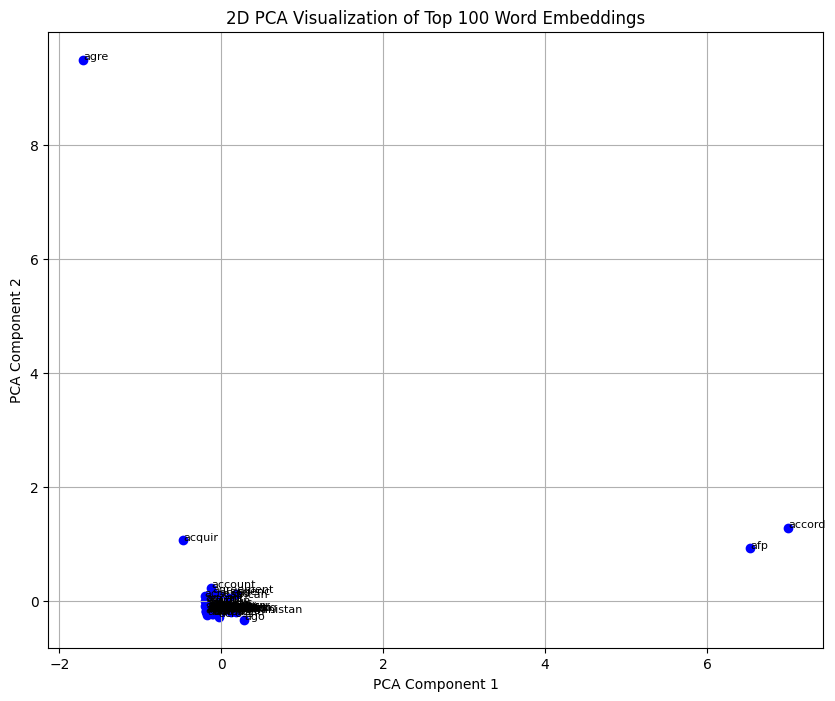

In [82]:
##Display Top Similar Pairs
# Print top 2 overall similar word pairs using cosine similarity on word TF-IDF vectors
top_pairs = top_similar_pairs(top_n=2)
print("Top 2 similar word pairs (similarity, word1, word2):")
for sim, w1, w2 in top_pairs:
    print(f"{sim:.4f}: {w1}, {w2}")

##PCA Visualization
num_words_to_plot = 100
tfidf_dense_subset = tfidf_sparse[:num_words_to_plot].toarray()

pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_dense_subset)

plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], color='blue')

for i, word in enumerate(feature_names[:num_words_to_plot]):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=8)

plt.title("2D PCA Visualization of Top 100 Word Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


PCA reduces high-dimensional TF-IDF vectors into 2D space. Visualizing
the top 100 words shows semantic proximity among them, satisfying the
assignment requirement of visualizing a subset of word embeddings.


**Conclusion**
This assignment demonstrated the use of probabilistic language models
for sentence recommendation and applied comprehensive preprocessing,
TF-IDF feature extraction, cosine similarity, and PCA visualization
for similarity analysis in textual data.

- The trigram language model (with Laplace smoothing) returns log-probabilities
  and showed which of the two given test sentences is more likely under the AG News corpus.
- The similarity analysis prints the top 2 most similar word pairs from the vocabulary
  and visualizes a PCA projection of selected word vectors for qualitative inspection.

In [83]:
# Additional: Robust trigram log-prob function and comparison (recompute counts if necessary)
from collections import Counter
import math

# Rebuild tokens for safety (in case previous cells were modified or not run)
def tokenize_with_bounds(texts):
    tokens = []
    for text in texts:
        words = word_tokenize(str(text).lower())
        words = ['<s>', '<s>'] + words + ['</s>']
        tokens.extend(words)
    return tokens

tokens2 = tokenize_with_bounds(df['description'].astype(str).tolist())
bigrams2, trigrams2 = [], []
for i in range(len(tokens2)-2):
    bigrams2.append((tokens2[i], tokens2[i+1]))
    trigrams2.append((tokens2[i], tokens2[i+1], tokens2[i+2]))
bigram_counts2 = Counter(bigrams2)
trigram_counts2 = Counter(trigrams2)
vocab_size2 = len(set(tokens2))

def trigram_log_probability_recompute(sentence, trigram_counts=trigram_counts2, bigram_counts=bigram_counts2, vocab_size=vocab_size2):
    words = word_tokenize(sentence.lower())
    words = ['<s>', '<s>'] + words + ['</s>']
    logp = 0.0
    for i in range(len(words)-2):
        tri = (words[i], words[i+1], words[i+2])
        bi = (words[i], words[i+1])
        tri_cnt = trigram_counts.get(tri, 0) + 1
        bi_cnt = bigram_counts.get(bi, 0) + vocab_size
        logp += math.log(tri_cnt) - math.log(bi_cnt)
    return logp

s1 = 'The stock market reached record highs amid economic recovery.'
s2 = 'Scientists discovered new evidence of water on Mars.'
log_s1 = trigram_log_probability_recompute(s1)
log_s2 = trigram_log_probability_recompute(s2)
print('Trigram log-probabilities (robust recompute):')
print('S1:', log_s1)
print('S2:', log_s2)
print('Most likely sentence under corpus:', 'S1' if log_s1 > log_s2 else 'S2')



Trigram log-probabilities (robust recompute):
S1: -103.90575553589998
S2: -97.79439348373609
Most likely sentence under corpus: S2


Top 2 similar word pairs (subset=100):
0.4783: acrobat, adob
0.1971: afghan, afghanistan


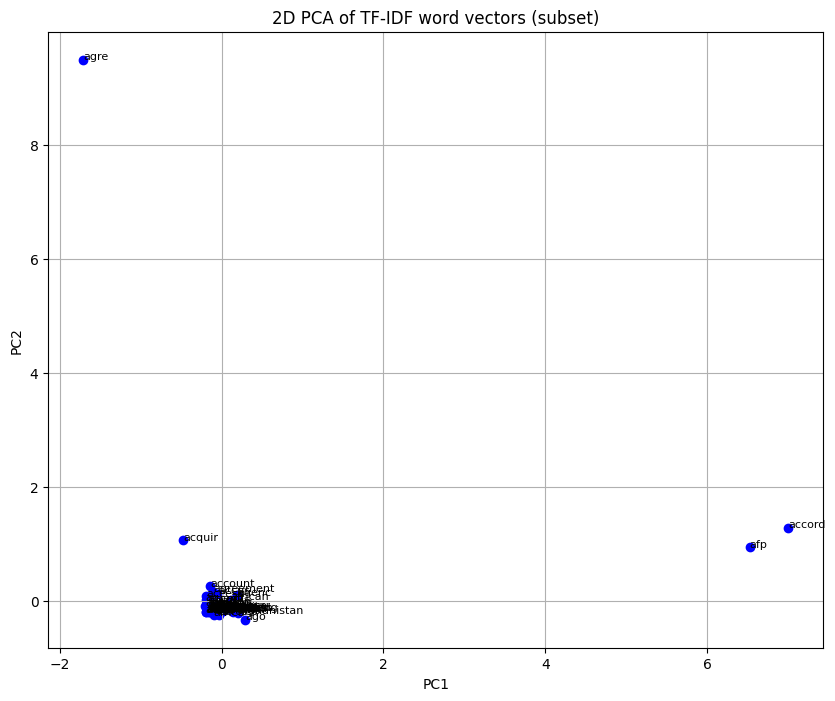

In [84]:
# Additional: compute top similar pairs and visualize only a subset (100 words) for performance
num_words_to_consider = 100
feature_names = tfidf.get_feature_names_out()
tfidf_sparse = tfidf_matrix.T
words_subset = feature_names[:num_words_to_consider]
word_vectors = tfidf_sparse[:num_words_to_consider].toarray()
sims = cosine_similarity(word_vectors)
np.fill_diagonal(sims, -1.0)
pairs = []
for i in range(num_words_to_consider):
    for j in range(i+1, num_words_to_consider):
        pairs.append((sims[i, j], words_subset[i], words_subset[j]))
pairs.sort(key=lambda x: x[0], reverse=True)
top_pairs = pairs[:2]
print('Top 2 similar word pairs (subset=%d):' % num_words_to_consider)
for sim, w1, w2 in top_pairs:
    print(f'{sim:.4f}: {w1}, {w2}')

# PCA visualization of the same subset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(word_vectors)
plt.figure(figsize=(10, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], color='blue')
for i, word in enumerate(words_subset):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]), fontsize=8)
plt.title('2D PCA of TF-IDF word vectors (subset)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()
